In [1]:
# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osr
import xarray as xr
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
import json
import dask
import itertools

# Import CSO gdf (metadata) and df (daily SWE data) 

In [2]:
gdf = gpd.read_file('../CSO_SNOTEL_sites.geojson')
df = pd.read_csv('../CSO_SNOTEL_data_SWEDmeters.csv') 
gdf.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (-110.44544 43.94019)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (-111.12803 44.50832)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (-109.79333 44.37667)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (-110.60973 42.96400)
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,607155.527746,4.839116e+06,POINT (-109.67021 43.69733)


# Import baseline .par parameters 

In [3]:
with open('par_base.json') as f:
    base = json.load(f)

base.keys()

dict_keys(['nx', 'ny', 'deltax', 'deltay', 'xmn', 'ymn', 'dt', 'iyear_init', 'imonth_init', 'iday_init', 'xhour_init', 'max_iter', 'isingle_stn_flag', 'igrads_metfile', 'met_input_fname', 'undef', 'ascii_topoveg', 'topoveg_grads_fname', 'topo_ascii_fname', 'veg_ascii_fname', 'ved_shd_25', 'ved_shd_26', 'ved_shd_27', 'ved_shd_28', 'ved_shd_29', 'ved_shd_30', 'const_veg_flag', 'iveg_ht_flag', 'xlat', 'lat_solar_flag', 'UTC_flag', 'run_micromet', 'run_enbal', 'run_snowpack', 'run_snowtran', 'irun_data_assim', 'ihrestart_flag', 'i_dataassim_loop', 'ihrestart_inc', 'i_tair_flag', 'i_rh_flag', 'i_wind_flag', 'i_solar_flag', 'i_longwave_flag', 'i_prec_flag', 'ifill', 'iobsint', 'dn', 'barnes_lg_domain', 'n_stns_used', 'snowmodel_line_flag', 'check_met_data', 'curve_len_scale', 'slopewt', 'curvewt', 'curve_lg_scale_flag', 'windspd_min', 'lapse_rate_user_flag', 'iprecip_lapse_rate_user_flag', 'iprecip_scheme', 'snowfall_frac', 'wind_lapse_rate', 'calc_subcanopy_met', 'gap_frac', 'cloud_frac_fac

# Function to edit text files 
## Edit snowmodel.par and snowmodel.inc to run SnowModel as line -> original code

In [4]:
#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

# Functions to adjust calibraiton parameters
## Edit snowmodel.par to run SnowModel as line -> Dave's code

In [5]:
parFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/snowmodel.par'
incFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/code/snowmodel.inc'
compileFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/code/compile_snowmodel.script'
ctlFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/ctl_files/wo_assim/swed.ctl'
sweFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/outputs/wo_assim/swed.gdat'

In [6]:
#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()

In [7]:
#edit snowmodel.par
edit_par(base,'nx',np.shape(gdf)[0])
edit_par(base,'ny',1)
edit_par(base,'xmn',487200)
edit_par(base,'ymn',4690100)
edit_par(base,'dt',21600)
edit_par(base,'iyear_init',2014)
edit_par(base,'imonth_init',10)
edit_par(base,'iday_init',1)
edit_par(base,'xhour_init',0)
edit_par(base,'max_iter',7300)
edit_par(base,'met_input_fname','met/mm_wy_2014-2019.dat')
edit_par(base,'ascii_topoveg',1)
edit_par(base,'topo_ascii_fname','topo_vege/DEM_WY.asc')
edit_par(base,'veg_ascii_fname','topo_vege/NLCD2016_WY.asc')
edit_par(base,'xlat',40.2)
edit_par(base,'run_snowtran',0)
edit_par(base,'barnes_lg_domain',1)
edit_par(base,'snowmodel_line_flag',1)
edit_par(base,'lapse_rate','.28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87')#
edit_par(base,'prec_lapse_rate','0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.32,0.43,0.39')#
edit_par(base,'print_inc',4)
edit_par(base,'print_var_01','y')
edit_par(base,'print_var_09','y')
edit_par(base,'print_var_10','y')
edit_par(base,'print_var_11','y')
edit_par(base,'print_var_12','y')
edit_par(base,'print_var_14','y')
edit_par(base,'print_var_18','y')
edit_par(base,'snowfall_frac',3)

##edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+str(np.shape(gdf)[0]+1)+',ny_max=2)\n')
#replace_line(incFile, 12, '      parameter (nx_max=1383,ny_max=2477)\n')#full domain


##edit compile_snowmodel.script
#replace_line(compileFile, 16, '#pgf77 -O3 -mcmodel=medium -I$path -o ../snowmodel $path$filename1 $path$filename2 $path$filename3 $path$filename4 $path$filename5 $path$filename6 $path$filename7 $path$filename8 $path$filename9 $path$filename10\n')
#replace_line(compileFile, 20, 'gfortran -O3 -mcmodel=medium -I$path -o ../snowmodel $path$filename1 $path$filename2 $path$filename3 $path$filename4 $path$filename5 $path$filename6 $path$filename7 $path$filename8 $path$filename9 $path$filename10\n')

# Function to compile/run SnowModel and extract relevant forcing parameters

In [8]:
#Compile SnowModel - with Dave's code - should only have to do this once
%cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/code/
#run compile script 
! ./compile_snowmodel.script
%cd  /nfs/attic/dfh/Aragon2/Notebooks/calibration_python

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


In [9]:
%%time

def runSnowModel():
    %cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/
    ! nohup ./snowmodel
    %cd  /nfs/attic/dfh/Aragon2/Notebooks/calibration_python

runSnowModel()

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python
CPU times: user 7.48 ms, sys: 16.2 ms, total: 23.7 ms
Wall time: 13.7 s


In [10]:
def get_mod_dims():
    #get model data from .ctl file 
    f=open(ctlFile)
    lines=f.readlines()
    nx = int(lines[9].split()[1])
    xll = int(float(lines[9].split()[3]))
    clsz = int(float(lines[9].split()[4]))
    ny = int(lines[10].split()[1])
    yll = int(float(lines[10].split()[3]))
    num_sim_days = int(lines[14].split()[1])
    st = datetime.strptime(lines[14].split()[3][3:], '%d%b%Y').date()
    ed = st + timedelta(days=(num_sim_days-1))
    print('nx=',nx,'ny=',ny,'xll=',xll,'yll=',yll,'clsz=',clsz,'num_sim_days=',num_sim_days,'start',st,'end',ed)
    f.close()
    return nx, ny, xll, yll, clsz, num_sim_days, st, ed

nx, ny, xll, yll, clsz, num_sim_days, st, ed = get_mod_dims()

nx= 30 ny= 1 xll= 487200 yll= 4690100 clsz= 100 num_sim_days= 1825 start 2014-10-01 end 2019-09-29


# Function to convert SnowModel output to numpy array

This function is to be used when running SnowModel as a line

In [11]:
## Build a function to convert the binary model output to numpy array

def get_mod_output_line(inFile,stn):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data 
    numpy_data = np.reshape(numpy_data,(num_sim_days,ny,nx))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,stn]) 

    return data

# Function for calculating performance statistics

In [18]:
#compute model performance metrics
def calc_metrics():
    swe_stats = np.zeros((5,np.shape(gdf)[0]))
    
    for i in range(np.shape(gdf)[0]):
        mod_swe = get_mod_output_line(sweFile,i)
        loc = gdf['code'][i]
        stn_swe = df[loc].values
        
        #remove days with zero SWE at BOTH the station and the SM pixel
        idx = np.where((stn_swe != 0) | (mod_swe != 0))
        mod_swe = mod_swe[idx]
        stn_swe = stn_swe[idx]
        
        #remove days where station has nan values 
        idx = np.where(~np.isnan(stn_swe))
        mod_swe = mod_swe[idx]
        stn_swe = stn_swe[idx]
        
        #R-squared value
        swe_stats[0,i] = np.corrcoef(stn_swe, mod_swe)[0,1]**2

        #mean bias error
        swe_stats[1,i] = (sum(mod_swe - stn_swe))/mod_swe.shape[0]

        #root mean squared error
        swe_stats[2,i] = np.sqrt((sum((mod_swe - stn_swe)**2))/mod_swe.shape[0])

        # Nash-Sutcliffe model efficiency coefficient, 1 = perfect, assumes normal data 
        nse_top = sum((mod_swe - stn_swe)**2)
        nse_bot = sum((stn_swe - mean(stn_swe))**2)
        swe_stats[3,i] = (1-(nse_top/nse_bot))

        # Kling-Gupta Efficiency, 1 = perfect
        kge_std = (np.std(mod_swe)/np.std(stn_swe))
        kge_mean = (mean(mod_swe)/mean(stn_swe))
        kge_r = corrcoef(stn_swe,mod_swe)[1,0]
        swe_stats[4,i] = (1 - (sqrt((kge_r-1)**2)+((kge_std-1)**2)+(kge_mean-1)**2))
    print(swe_stats)
        
    return swe_stats

swe_stats = calc_metrics()

[[ 4.27530622e-01  7.61746311e-01  7.91137867e-01  7.99204445e-01
   8.09178049e-01  8.05994180e-01  3.92168078e-01  8.71700143e-01
   8.28671361e-01  4.35432617e-01  8.46131769e-01  7.52700053e-01
   8.76699937e-01  5.40639380e-01  9.07542275e-01  9.03863558e-01
   7.43225068e-01  6.79187025e-01  8.37738718e-01  6.06284869e-01
   3.45328695e-01  6.57370729e-01  6.16459739e-01  9.28801561e-01
   1.46230752e-01  4.70366072e-01  8.79054758e-01  8.17923944e-01
   9.45295772e-01  8.49951582e-01]
 [ 1.46540076e-01 -3.05401271e-01 -2.65615661e-01 -2.38274334e-01
  -7.79598806e-02 -1.24889378e-01  8.04938934e-02 -5.24942307e-02
  -3.13328294e-01  1.43932792e-01 -7.73002982e-02  8.52287067e-02
  -3.50009444e-02  2.67262942e-02 -9.17170319e-02 -3.46665190e-02
   2.65499690e-03  9.26816833e-03  8.13435025e-02  2.63955428e-02
   1.72557119e-01  1.10274791e-02 -2.49527646e-01 -8.21824512e-03
   1.38975204e-01  1.86687684e-01 -1.47148806e-01 -1.80270100e-01
  -1.58178120e-01 -2.01373764e-01]
 [ 2.5

# function to calculate indicator snow metrics
Not finished. Figure out how to handle multiple years of data. 
Could consider: 
* taking the average of the 5 years
* storing a 3D grid
* calculating stats on an annual basis too. 

In [14]:
mod_swe = get_mod_output_line(sweFile,1)
loc = gdf['code'][1]
stn_swe = df[loc].values

In [ ]:
def calc_snow_metrics(in_swe):
    swe_values = np.zeros((3,np.shape(gdf)[0]))
    for i in range(np.shape(gdf)[0]):
        mod_swe = get_mod_output_line(sweFile,i)
        loc = gdf['code'][i]
        stn_swe = df[loc].values
    
    # this gets the swe series for one year 
    for x in range(int(len(in_swe)/365)):
        st = x*365
        ed = st + 365
        sweyr= in_swe[st:ed]    

        
        #indicator swe values
        
        #DOY of snow disappearance
        #index of maximum swe
        idx = np.argmax(sweyr)
        #index of DOYs with zero swe
        zro = np.where(sweyr == 0)
        # index of first day of zero swe after peak swe
        DOY = zro[0][zro[0]>idx][0]+1

        #maximum swe
        swe_values[0,i] = np.max(swe_yr)
        
        # number of snow covered days 
        swe_values[1,i]=len(swe_yr[swe_yr >0])
        

# Sample parameter space

[[3.e+02 7.e+02]
 [5.e-01 2.e+00]
 [2.e+00 6.e+00]]
(500, 3)


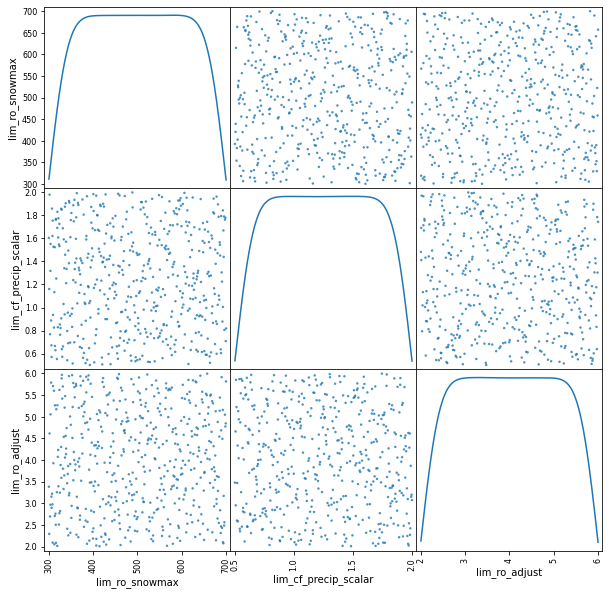

,lim_ro_snowmax,lim_cf_precip_scalar,lim_ro_adjust
0,600.612489,1.086788,5.430774
1,511.124553,0.580955,2.789796
2,425.515553,1.114269,2.649703
3,371.358005,1.427092,5.933815
4,620.997787,1.630378,3.770536


In [11]:
# generate parameter sets using latin hypercube sampling
 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from smt.sampling_methods import LHS

# set sampling range for each parameter


lim_ro_snowmax=[300,700]

lim_cf_precip_scalar=[.5,2]
# add cf_precip_flag = 3
lim_ro_adjust=[2,6]

xlimits = np.array([lim_ro_snowmax, lim_cf_precip_scalar, lim_ro_adjust])
print (xlimits)

# 'maximin' : maximize the minimum distance between sampled points
sampling = LHS(xlimits=xlimits,criterion='maximin')
# set the number of parameter sets
num = 500
x = sampling(num)
print(x.shape)

# Pairs plot to visualize sampled space.
data = pd.DataFrame(x,columns=['lim_ro_snowmax', 'lim_cf_precip_scalar', 'lim_ro_adjust'])
fig = pd.plotting.scatter_matrix(data, figsize=(10,10), marker = 'o', diagonal='kde', s = 6, alpha = 0.8)
plt.show()
data.head()
#np.savetxt('parametersets.txt', x, delimiter=' ',fmt='%1.4f')

# Create dataframe of calibration parameters and run calibration

In [ ]:
#Calibration parameters with physical basis - remove on/off switches 

#snowfall_frac = [1,2,3]
#if = 1 -> 
#T_threshold = arange(float(base ['T_threshold'][0])-2,float(base ['T_threshold'][0])+2,1)
#if = 3 -> base['T_Left,T_Right']
#figure out how to parse these 

#snowfall_frac = [3]
T_L_R = [base['T_Left,T_Right'][0],'-2,1','-2,2','-2,3','-1,1','-1,2','-1,3','0,2','0,3']


wind_lapse_rate = arange(float(base ['wind_lapse_rate'][0]),
#                  float(base ['wind_lapse_rate'][0])+1.5,.5)
gap_frac = arange(0,.8,.2)

#lat_solar_flag = [0,1]

# figure out how to adjust these smoothly - perhaps a gradient from original to these?                         
lapse_rate= [base['lapse_rate'][0],
             '.28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87']
prec_lapse_rate = [base ['prec_lapse_rate'][0],
                   '0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.32,0.43,0.39']

ro_snowmax=arange(float(base ['ro_snowmax'][0])-250,
                  float(base ['ro_snowmax'][0])+200,50)

cf_precip_scalar=arange(float(base ['cf_precip_scalar'][0])-.3,
                        float(base ['cf_precip_scalar'][0])+.2,.1)
# add cf_precip_flag = 3
ro_adjust=arange(float(base ['ro_adjust'][0])-1,
                 float(base ['ro_adjust'][0])+2,1)

Total_runs = len(lat_solar_flag) * len(use_shortwave_obs)* \
len(use_longwave_obs) * len(lapse_rate) * len(prec_lapse_rate) * \
len(ro_snowmax)*len(cf_precip_scalar)*len(ro_adjust)
print('Total number of calibration runs = ',Total_runs)

In [15]:
#Calibration parameters

#snowfall_frac = [1,2,3]
#if = 1 -> 
#T_threshold = arange(float(base ['T_threshold'][0])-2,float(base ['T_threshold'][0])+2,1)
#if = 3 -> base['T_Left,T_Right']
#figure out how to parse these 

#snowfall_frac = [3]
#T_L_R = [base['T_Left,T_Right'][0],'-2,1','-2,2','-2,3','-1,1','-1,2','-1,3','0,2','0,3']


#wind_lapse_rate = arange(float(base ['wind_lapse_rate'][0]),
#                  float(base ['wind_lapse_rate'][0])+1.5,.5)
#gap_frac = arange(.2,1,.2)

lat_solar_flag = [0,1]

use_shortwave_obs = [0,1]

use_longwave_obs = [0,1]

lapse_rate= [base['lapse_rate'][0],
             '.28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87']
prec_lapse_rate = [base ['prec_lapse_rate'][0],
                   '0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.32,0.43,0.39']

ro_snowmax=arange(float(base ['ro_snowmax'][0])-250,
                  float(base ['ro_snowmax'][0])+200,50)

cf_precip_scalar=arange(float(base ['cf_precip_scalar'][0])-.3,
                        float(base ['cf_precip_scalar'][0])+.2,.1)
# add cf_precip_flag = 3
ro_adjust=arange(float(base ['ro_adjust'][0])-1,
                 float(base ['ro_adjust'][0])+2,1)

Total_runs = len(lat_solar_flag) * len(use_shortwave_obs)* \
len(use_longwave_obs) * len(lapse_rate) * len(prec_lapse_rate) * \
len(ro_snowmax)*len(cf_precip_scalar)*len(ro_adjust)
print('Total number of calibration runs = ',Total_runs)

Total number of calibration runs =  4320


In [16]:
parameters = [lat_solar_flag,use_shortwave_obs,use_longwave_obs,lapse_rate,
              prec_lapse_rate,ro_snowmax,cf_precip_scalar,ro_adjust]
data = list(itertools.product(*parameters))
input_params = pd.DataFrame(data,columns=['lat_solar_flag','use_shortwave_obs',
                                          'use_longwave_obs','lapse_rate','prec_lapse_rate',
                                          'ro_snowmax','cf_precip_scalar','ro_adjust'])
input_params

,lat_solar_flag,use_shortwave_obs,use_longwave_obs,lapse_rate,prec_lapse_rate,ro_snowmax,cf_precip_scalar,ro_adjust
0,0,0,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",300.0,0.7,4.0
1,0,0,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",300.0,0.7,5.0
2,0,0,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",300.0,0.7,6.0
3,0,0,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",300.0,0.8,4.0
4,0,0,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",300.0,0.8,5.0
...,...,...,...,...,...,...,...,...
4315,1,1,1,".28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",700.0,1.0,5.0
4316,1,1,1,".28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",700.0,1.0,6.0
4317,1,1,1,".28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",700.0,1.1,4.0
4318,1,1,1,".28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",700.0,1.1,5.0


In [17]:
timestamp = str(datetime.date(datetime.now()))

#save input parameters as csv
input_params.to_csv('cal_params_'+timestamp+'.csv',index=False)

In [15]:
%%time
%cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/

swe_stats = np.empty([shape(input_params)[0],5,np.shape(gdf)[0]])
for i in np.arange(0,10):#range(np.shape(input_params)[0]):
    edit_par(base,'lat_solar_flag',input_params.lat_solar_flag[i])
    edit_par(base,'use_shortwave_obs',input_params.use_shortwave_obs[i])
    edit_par(base,'use_longwave_obs',input_params.use_longwave_obs[i])
    edit_par(base,'lapse_rate',input_params.lapse_rate[i])
    edit_par(base,'prec_lapse_rate',input_params.prec_lapse_rate[i])
    edit_par(base,'ro_snowmax',input_params.ro_snowmax[i])
    edit_par(base,'cf_precip_scalar',input_params.cf_precip_scalar[i])
    #edit_par(base,'ro_adjust',input_params.ro_adjust[i])
    ! nohup ./snowmodel
    swe_stats[i,:,:] = calc_metrics()

%cd  /nfs/attic/dfh/Aragon2/Notebooks/calibration_python

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input an

# Save output as netcdf

In [16]:
#Turn NDarray into xarray 
calibration_run = np.arange(0,swe_stats.shape[0],1)
metric = ['R_2','MBE','RMSE','NSE','KGE']
station = gdf['code'].values

cailbration = xr.DataArray(
    swe_stats,
    dims=('calibration_run', 'metric', 'station'), 
    coords={'calibration_run': calibration_run, 
            'metric': metric, 'station': station})

cailbration.attrs['long_name']= 'Calibration performance metrics'
cailbration.attrs['standard_name']= 'cal_metrics'

d = OrderedDict()
d['calibration_run'] = ('calibration_run', calibration_run)
d['metric'] = ('metric', metric)
d['station'] = ('station', station)
d['cal_metrics'] = cailbration

ds = xr.Dataset(d)
ds.attrs['description'] = "SnowModel line calibration performance metrics"
ds.attrs['calibration_parameters'] = "ro_snowmax,cf_precip_scalar,ro_adjust"
ds.attrs['model_parameter'] = "SWE [m]"

ds.calibration_run.attrs['standard_name'] = "calibration_run"
ds.calibration_run.attrs['axis'] = "N"

ds.metric.attrs['long_name'] = "calibration_metric"
ds.metric.attrs['axis'] = "metric"

ds.station.attrs['long_name'] = "station_id"
ds.station.attrs['axis'] = "station"
ds

In [ ]:
#export to netcdf
ds.to_netcdf('calibration_'+timestamp+'.nc', format='NETCDF4', engine='netcdf4')
#test
#ds_read = xr.open_dataset('calibration_test.nc')
#ds_read

# Test calibration

In [13]:
#Calibration parameters

ro_snowmax=arange(float(base ['ro_snowmax'][0])-250,
                  float(base ['ro_snowmax'][0])+200,25)

cf_precip_scalar=arange(float(base ['cf_precip_scalar'][0])-.3,
                        float(base ['cf_precip_scalar'][0])+.2,.1)
# add cf_precip_flag = 3
ro_adjust=arange(float(base ['ro_adjust'][0])-2,
                 float(base ['ro_adjust'][0])+3,1)

Total_runs = len(ro_snowmax)*len(cf_precip_scalar)*len(ro_adjust)
print('Total number of calibration runs = ',Total_runs)

Total number of calibration runs =  450


In [14]:
parameters = [ro_snowmax,cf_precip_scalar,ro_adjust]
data = list(itertools.product(*parameters))
input_params = pd.DataFrame(data,columns=['ro_snowmax','cf_precip_scalar','ro_adjust'])
input_params

,ro_snowmax,cf_precip_scalar,ro_adjust
0,300.0,0.7,3.0
1,300.0,0.7,4.0
2,300.0,0.7,5.0
3,300.0,0.7,6.0
4,300.0,0.7,7.0
...,...,...,...
445,725.0,1.1,3.0
446,725.0,1.1,4.0
447,725.0,1.1,5.0
448,725.0,1.1,6.0


In [15]:
timestamp = str(datetime.date(datetime.now()))

#save input parameters as csv
input_params.to_csv('cal_params_'+timestamp+'.csv',index=False)

In [16]:
%%time
%cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill/

swe_stats = np.empty([shape(input_params)[0],5,np.shape(gdf)[0]])
for i in range(np.shape(input_params)[0]):
    edit_par(base,'ro_snowmax',input_params.ro_snowmax[i])
    edit_par(base,'cf_precip_scalar',input_params.cf_precip_scalar[i])
    edit_par(base,'ro_adjust',input_params.ro_adjust[i])
    ! nohup ./snowmodel
    swe_stats[i,:,:] = calc_metrics()

%cd  /nfs/attic/dfh/Aragon2/Notebooks/calibration_python

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input an

In [17]:
#Turn NDarray into xarray 
calibration_run = np.arange(0,swe_stats.shape[0],1)
metric = ['MAE','MBE','RMSE','NSE','KGE']
station = gdf['code'].values

cailbration = xr.DataArray(
    swe_stats,
    dims=('calibration_run', 'metric', 'station'), 
    coords={'calibration_run': calibration_run, 
            'metric': metric, 'station': station})

cailbration.attrs['long_name']= 'Calibration performance metrics'
cailbration.attrs['standard_name']= 'cal_metrics'

d = OrderedDict()
d['calibration_run'] = ('calibration_run', calibration_run)
d['metric'] = ('metric', metric)
d['station'] = ('station', station)
d['cal_metrics'] = cailbration

ds = xr.Dataset(d)
ds.attrs['description'] = "SnowModel line calibration performance metrics"
ds.attrs['calibration_parameters'] = "ro_snowmax,cf_precip_scalar,ro_adjust"
ds.attrs['model_parameter'] = "SWE [m]"

ds.calibration_run.attrs['standard_name'] = "calibration_run"
ds.calibration_run.attrs['axis'] = "N"

ds.metric.attrs['long_name'] = "calibration_metric"
ds.metric.attrs['axis'] = "metric"

ds.station.attrs['long_name'] = "station_id"
ds.station.attrs['axis'] = "station"
ds

<xarray.Dataset>
Dimensions:          (calibration_run: 450, metric: 5, station: 30)
Coordinates:
  * calibration_run  (calibration_run) int64 0 1 2 3 4 5 ... 445 446 447 448 449
  * metric           (metric) <U4 'MAE' 'MBE' 'RMSE' 'NSE' 'KGE'
  * station          (station) object '314_WY_SNTL' ... '868_WY_SNTL'
Data variables:
    cal_metrics      (calibration_run, metric, station) float64 0.114 ... 0.561
Attributes:
    description:             SnowModel line calibration performance metrics
    calibration_parameters:  ro_snowmax,cf_precip_scalar,ro_adjust
    model_parameter:         SWE [m]

In [18]:
ds.to_netcdf('calibration_'+timestamp+'.nc', format='NETCDF4', engine='netcdf4')